<a href="https://colab.research.google.com/github/suafle/Clase2/blob/master/protostar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import rc
from astropy import units as u
from astropy.io import fits

In [0]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size':24})
rc('text', usetex=True)

In [4]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

! sudo apt-get install msttcorefonts -q
! sudo apt-get install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  lib

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


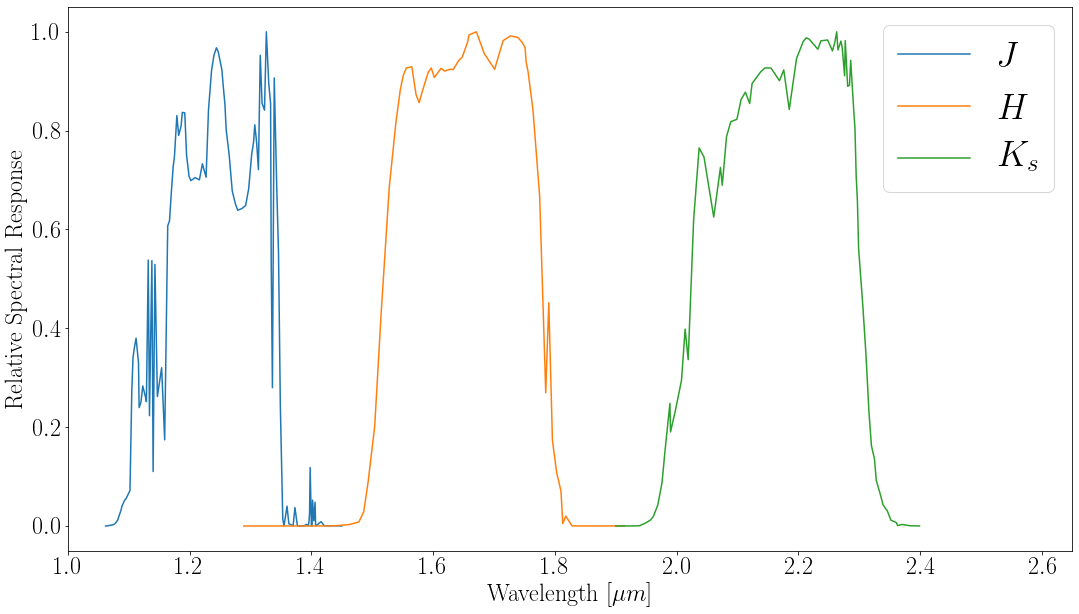

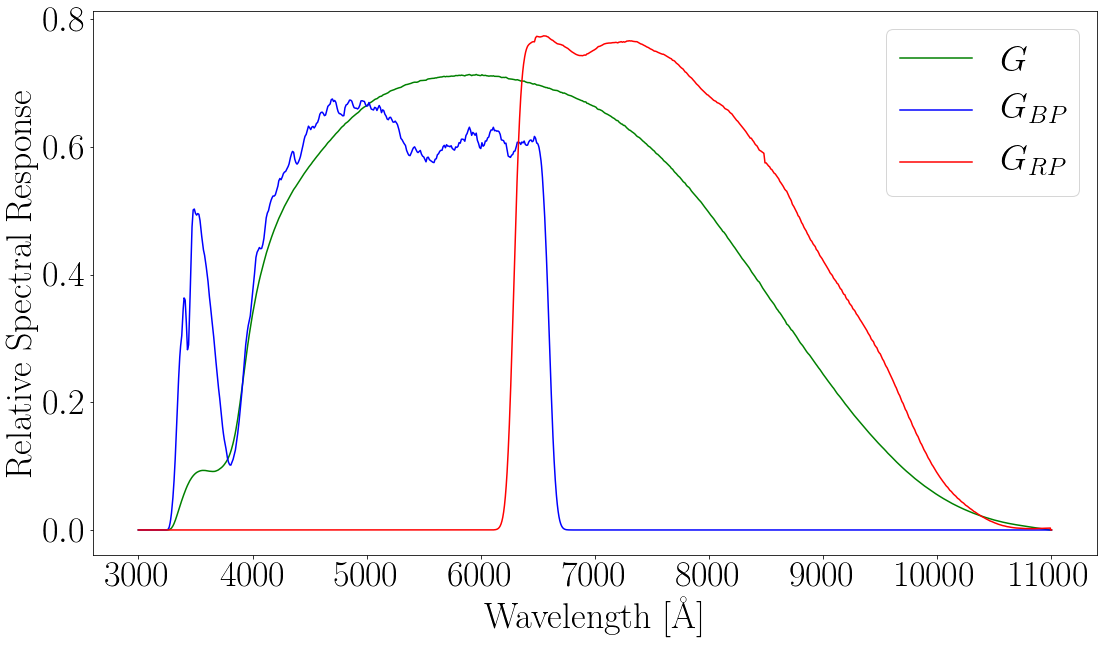

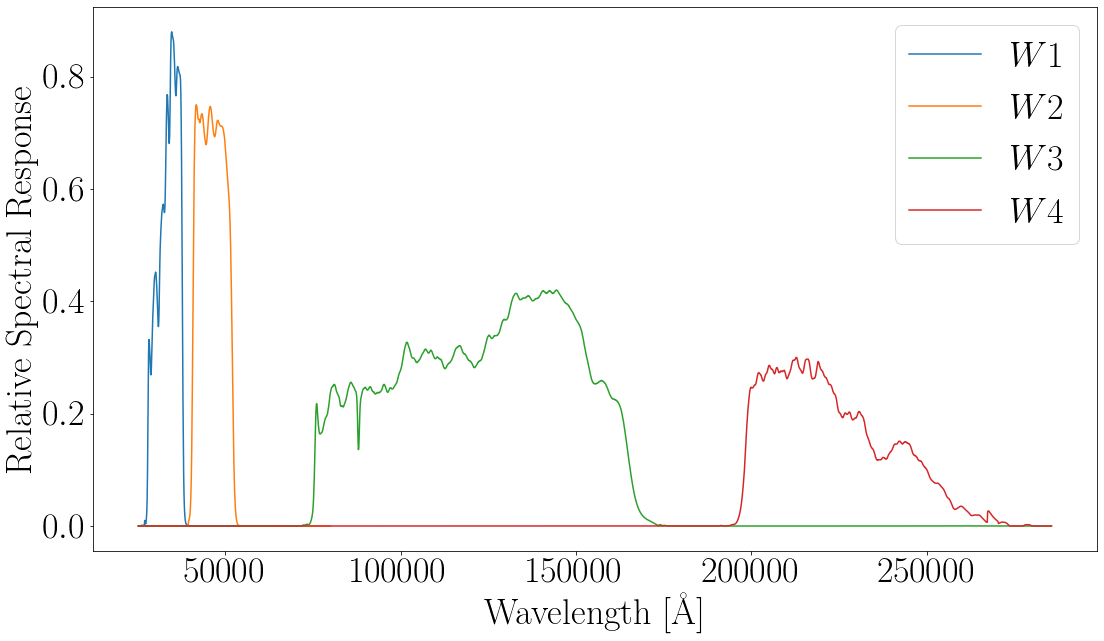

In [5]:
#2MASS passbands
mass_j = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/2MASS/2MASS_J.txt'
mass_h = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/2MASS/2MASS_H.txt'
mass_ks = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/2MASS/2MASS_Ks.txt'

tmass_j = np.loadtxt(mass_j)
tmass_h = np.loadtxt(mass_h)
tmass_ks = np.loadtxt(mass_ks)

c = 2.99792e8 #m s^-1
cm = c*1e6 #microns s**-1
cA = c*1e10 #A s**-1

def inter_j(wavelength): #wavelength must be in A in the range of 10620 and 14500 A
  f = interp1d(tmass_j[:,0]*1e4,tmass_j[:,1])
  return f(wavelength)
  
def inter_h(wavelength): #wavelength must be in A in the range of 12890 and 19140 A
  f = interp1d(tmass_h[:,0]*1e4,tmass_h[:,1])
  return f(wavelength)
  
def inter_ks(wavelength): #wavelength must be in A in the range of 19000 and 23990 A
  f = interp1d(tmass_ks[:,0]*1e4,tmass_ks[:,1])
  return f(wavelength)


fig, ax = plt.subplots(figsize=(18,10))
matplotlib.rcParams.update({'font.size': 36})

plt.plot(tmass_j[:,0],tmass_j[:,1],label='$J$')
plt.plot(tmass_h[:,0],tmass_h[:,1],label='$H$')
plt.plot(tmass_ks[:,0],tmass_ks[:,1],label='$K_{s}$')
plt.xlim([1.0,2.65])
plt.xlabel('Wavelength [$\mu m$]')
plt.ylabel('Relative Spectral Response')
plt.legend(loc=1)
plt.show()
plt.close()


#GAIA passbands
gaia_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/GAIADR2/GaiaDR2_RevisedPassbands.dat'
gaia = np.loadtxt(gaia_data)

gaia = np.where(gaia==99.99,0,gaia)

gaia_w = gaia[:,0]*10 #Angstrom
gaia_g = gaia[:,1]
gaia_bp = gaia[:,3]
gaia_rp = gaia[:,5]

def inter_g(wavelength): 
  f = interp1d(gaia_w,gaia_g)
  return f(wavelength)
  
def inter_gbp(wavelength): 
  f = interp1d(gaia_w,gaia_bp)
  return f(wavelength)
  
def inter_grp(wavelength): 
  f = interp1d(gaia_w,gaia_rp)
  return f(wavelength)

fig, ax = plt.subplots(figsize=(18,10))
matplotlib.rcParams.update({'font.size': 36})

plt.plot(gaia_w,gaia_g,label='$G$',color='green')
plt.plot(gaia_w,gaia_bp,label=r'$G_{BP}$',color='blue')
plt.plot(gaia_w,gaia_rp,label=r'$G_{RP}$',color='red')
plt.xlabel('Wavelength [\AA]')
plt.ylabel('Relative Spectral Response')
plt.legend(loc=1)
plt.show()
plt.close()

#WISE passbands
wise1_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W1.txt'
wise2_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W2.txt'
wise3_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W3.txt'
wise4_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W4.txt'

w1 = np.loadtxt(wise1_data)
w2 = np.loadtxt(wise2_data)
w3 = np.loadtxt(wise3_data)
w4 = np.loadtxt(wise4_data)

w1ww = w1[:,0]*1e4
w1r = w1[:,1]

w2ww = w2[:,0]*1e4
w2r = w2[:,1]

w3ww = w3[:,0]*1e4
w3r = w3[:,1]

w4ww = w4[:,0]*1e4
w4r = w4[:,1]

#wavelength must be between 25300 and 65000 A (W1)
#wavelength must be between 25300 and 80000 A (W1)
#wavelength must be between 25300 and 285000 A (W1)
#wavelength must be between 25300 and 285000 A (W1)


def inter_w1(wavelength): 
  f = interp1d(w1ww,w1r)
  return f(wavelength)
  
def inter_w2(wavelength): 
  f = interp1d(w2ww,w2r)
  return f(wavelength)

def inter_w3(wavelength): 
  f = interp1d(w3ww,w3r)
  return f(wavelength)

def inter_w4(wavelength): 
  f = interp1d(w4ww,w4r)
  return f(wavelength)

fig, ax = plt.subplots(figsize=(18,10))
matplotlib.rcParams.update({'font.size': 36})

plt.plot(w1ww,w1r,label='$W1$')
plt.plot(w2ww,w2r,label='$W2$')
plt.plot(w3ww,w3r,label='$W3$')
plt.plot(w4ww,w4r,label='$W4$')
plt.xlabel('Wavelength [\AA]')
plt.ylabel('Relative Spectral Response')
plt.legend()
plt.show()
plt.close()

In [0]:
#Single object
#Vaga magnitudes

#L must be in Lsun
def BB_W1(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,65100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,65000,1)
  f = np.trapz(fgaia(ww) * inter_w1(ww) * ww, x=ww) / np.trapz(inter_w1(ww) * cA / ww, x=ww)
  w1 =  -2.5 * np.log10(f) - 48.60
  return w1 - 2.699
  
  
def BB_W2(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,80100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,80000,1)
  f = np.trapz(fgaia(ww) * inter_w2(ww) * ww, x=ww) / np.trapz(inter_w2(ww) * cA / ww, x=ww)
  w2 =  -2.5 * np.log10(f) - 48.60
  return w2 - 3.339
  
  
def BB_W3(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w3(ww) * ww, x=ww) / np.trapz(inter_w3(ww) * cA / ww, x=ww)
  w3 =  -2.5 * np.log10(f) - 48.60
  return w3 - 5.174
  
  
def BB_W4(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w4(ww) * ww, x=ww) / np.trapz(inter_w4(ww) * cA / ww, x=ww)
  w4 =  -2.5 * np.log10(f) - 48.60
  return w4 - 6.620
 
  
def BB_G(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(2900,11100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(3000,11000,1)
  f = np.trapz(fgaia(ww) * inter_g(ww) * ww, x=ww) / np.trapz(inter_g(ww) * cA / ww, x=ww)
  g =  -2.5 * np.log10(f) - 48.60
  return g - 25.7915509947 + 25.6914396869


def BB_J(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(10610,14510,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(10620,14500,1)
  f = np.trapz(fgaia(ww) * inter_j(ww) * ww, x=ww) / np.trapz(inter_j(ww) * cA / ww, x=ww)
  j =  -2.5 * np.log10(f) - 48.60
  return j - 0.91

def BB_H(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(12880,19150,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(12890,19140,1)
  f = np.trapz(fgaia(ww) * inter_h(ww) * ww, x=ww) / np.trapz(inter_h(ww) * cA / ww, x=ww)
  h =  -2.5 * np.log10(f) - 48.60
  return h - 1.39


def BB_K(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(18990,24000,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(19000,23990,1)
  f = np.trapz(fgaia(ww) * inter_ks(ww) * ww, x=ww) / np.trapz(inter_ks(ww) * cA / ww, x=ww)
  k =  -2.5 * np.log10(f) - 48.60
  return k - 1.85


def W1_DS(W1,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  W1star = W1 - 2.5*np.log10(1 - eta)
  
  ww1 = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    W1DS = BB_W1(TDS,Lbol_DS)
    new_w1 = -2.5*np.log10(10**(W1star[i]/-2.5) + 10**(W1DS/-2.5))
    ww1 = np.append(ww1,new_w1) 
  
  return ww1
  
  
def W2_DS(W2,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  W2star = W2 - 2.5*np.log10(1 - eta)
  
  ww2 = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    W2DS = BB_W2(TDS,Lbol_DS)
    new_w2 = -2.5*np.log10(10**(W2star[i]/-2.5) + 10**(W2DS/-2.5))
    ww2 = np.append(ww2,new_w2) 
  
  return ww2
  
  
def W3_DS(W3,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  W3star = W3 - 2.5*np.log10(1 - eta)
  
  ww3 = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    W3DS = BB_W3(TDS,Lbol_DS)
    new_w3 = -2.5*np.log10(10**(W3star[i]/-2.5) + 10**(W3DS/-2.5))
    ww3 = np.append(ww3,new_w3) 
  
  return ww3
  
def W4_DS(W4,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  W4star = W4 - 2.5*np.log10(1 - eta)
  
  ww4 = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    W4DS = BB_W4(TDS,Lbol_DS)
    new_w4 = -2.5*np.log10(10**(W4star[i]/-2.5) + 10**(W4DS/-2.5))
    ww4 = np.append(ww4,new_w4) 
  
  return ww4
  
  
def G_DS(G,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  Gstar = G - 2.5*np.log10(1 - eta)
  
  gg = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    GDS = BB_G(TDS,Lbol_DS)
    new_g = -2.5*np.log10(10**(Gstar[i]/-2.5) + 10**(GDS/-2.5))
    gg = np.append(gg,new_g) 
  return gg


def J_DS(J,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  Jstar = J - 2.5*np.log10(1 - eta)
  
  jj = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    JDS = BB_J(TDS,Lbol_DS)
    new_j = -2.5*np.log10(10**(Jstar[i]/-2.5) + 10**(JDS/-2.5))
    jj = np.append(jj,new_j) 
  return jj


def H_DS(H,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  Hstar = H - 2.5*np.log10(1 - eta)
  
  hh = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    HDS = BB_H(TDS,Lbol_DS)
    new_h = -2.5*np.log10(10**(Hstar[i]/-2.5) + 10**(HDS/-2.5))
    hh = np.append(hh,new_h) 
  return hh


def K_DS(K,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  Kstar = K - 2.5*np.log10(1 - eta)
  
  kk = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    KDS = BB_K(TDS,Lbol_DS)
    new_k = -2.5*np.log10(10**(Kstar[i]/-2.5) + 10**(KDS/-2.5))
    kk = np.append(kk,new_k) 
  return kk

In [0]:
#Parsec models
#Including everything
#Synthetic models

#Column orden UBV
#Zini MH logAge Mini int_IMF Mass logL logTe logg label       0-9
#McoreTP C_O period0 period1 pmode Mloss tau1m X Y Xc         10-19
#Xn Xo Cexcess Z mbolmag Umag Bmag Vmag Rmag Imag             20-29
#Jmag Hmag Kmag                                               30-32

#Column order GAIA
#Zini MH logAge Mini int_IMF Mass logL logTe logg label       0-9
#McoreTP C_O period0 period1 pmode Mloss tau1m X Y Xc         10-19
#Xn Xo Cexcess Z mbolmag Gmag G_BPmag G_RPmag     20-27

#Column order WISE
#Zini MH logAge Mini int_IMF Mass logL logTe logg label       0-9
#McoreTP C_O period0 period1 pmode Mloss tau1m X Y Xc         10-19
#Xn Xo Cexcess Z mbolmag Jmag Hmag Ksmag IRAC_3.6mag IRAC_4.5mag   20 - 29
#IRAC_5.8mag IRAC_8.0mag MIPS_24mag MIPS_70mag MIPS_160mag W1mag W2mag W3mag W4mag    30 - 38

#The IMF does not matter that much
file1 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/UBV(1e5).txt'
file2 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/GAIA(1e5).txt'
file3 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/WISE(1e5).txt'
file4 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/UBV(1e6).txt'
file5 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/GAIA(1e6).txt'
file6 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/WISE(1e6).txt'
file7 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/UBV(1e7).txt'
file8 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/GAIA(1e7).txt'
file9 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/WISE(1e7).txt'
file10 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/UBV(1e8).txt'
file11 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/GAIA(1e8).txt'
file12 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/WISE(1e8).txt'
file13 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/UBV(1e9).txt'
file14 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/GAIA(1e9).txt'
file15 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/WISE(1e9).txt'
file16 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/UBV(1e10).txt'
file17 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/GAIA(1e10).txt'
file18 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/WISE(1e10).txt'

file19 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/GAIA(1e10)_Z(0.02).txt'
file20 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/WISE(1e10)_Z(0.02).txt'

file21 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/GAIA(1e10)_Z(0.03).txt'
file22 = 'https://raw.githubusercontent.com/suafle/useful_data/master/PARSEC/WISE(1e10)_Z(0.03).txt'

data1 = np.loadtxt(file1)
data2 = np.loadtxt(file2)
data3 = np.loadtxt(file3)
data4 = np.loadtxt(file4)
data5 = np.loadtxt(file5)
data6 = np.loadtxt(file6)
data7 = np.loadtxt(file7)
data8 = np.loadtxt(file8)
data9 = np.loadtxt(file9)
data10 = np.loadtxt(file10)
data11 = np.loadtxt(file11)
data12 = np.loadtxt(file12)
data13 = np.loadtxt(file13)
data14 = np.loadtxt(file14)
data15 = np.loadtxt(file15)
data16 = np.loadtxt(file16)
data17 = np.loadtxt(file17)
data18 = np.loadtxt(file18)
data19 = np.loadtxt(file19)
data20 = np.loadtxt(file20)
data21 = np.loadtxt(file21)
data22 = np.loadtxt(file22)

L1 = data1[:,6][:-1]
U1 = data1[:,25][:-1]
B1 = data1[:,26][:-1]
V1 = data1[:,27][:-1]
R1 = data1[:,28][:-1]
I1 = data1[:,29][:-1]
G1 = data2[:,25][:-1]
BP1 = data2[:,26][:-1]
RP1 = data2[:,27][:-1]
J1 = data3[:,25][:-1]
H1 = data3[:,26][:-1]
K1 = data3[:,27][:-1]
W1_1 = data3[:,35][:-1]
W2_1 = data3[:,36][:-1]
W3_1 = data3[:,37][:-1]
W4_1 = data3[:,38][:-1]

T1 = data3[:,7][:-1]
label1 = data1[:,9][:-1]


L2 = data4[:,6][:-1]
U2 = data4[:,25][:-1]
B2 = data4[:,26][:-1]
V2 = data4[:,27][:-1]
R2 = data4[:,28][:-1]
I2 = data4[:,29][:-1]
G2 = data5[:,25][:-1]
BP2 = data5[:,26][:-1]
RP2 = data5[:,27][:-1]
J2 = data6[:,25][:-1]
H2 = data6[:,26][:-1]
K2 = data6[:,27][:-1]
W1_2 = data6[:,35][:-1]
W2_2 = data6[:,36][:-1]
W3_2 = data6[:,37][:-1]
W4_2 = data6[:,38][:-1]

T2 = data6[:,7][:-1]
label2 = data4[:,9][:-1]


L3 = data7[:,6][:-1]
U3 = data7[:,25][:-1]
B3 = data7[:,26][:-1]
V3 = data7[:,27][:-1]
R3 = data7[:,28][:-1]
I3 = data7[:,29][:-1]
G3 = data8[:,25][:-1]
BP3 = data8[:,26][:-1]
RP3 = data8[:,27][:-1]
J3 = data9[:,25][:-1]
H3 = data9[:,26][:-1]
K3 = data9[:,27][:-1]
W1_3 = data9[:,35][:-1]
W2_3 = data9[:,36][:-1]
W3_3 = data9[:,37][:-1]
W4_3 = data9[:,38][:-1]

T3 = data7[:,7][:-1]
label3 = data7[:,9][:-1]


L4 = data10[:,6][:-1]
U4 = data10[:,25][:-1]
B4 = data10[:,26][:-1]
V4 = data10[:,27][:-1]
R4 = data10[:,28][:-1]
I4 = data10[:,29][:-1]
G4 = data11[:,25][:-1]
BP4 = data11[:,26][:-1]
RP4 = data11[:,27][:-1]
J4 = data12[:,25][:-1]
H4 = data12[:,26][:-1]
K4 = data12[:,27][:-1]
W1_4 = data12[:,35][:-1]
W2_4 = data12[:,36][:-1]
W3_4 = data12[:,37][:-1]
W4_4 = data12[:,38][:-1]

T4 = data10[:,7][:-1]
label4 = data10[:,9][:-1]


L5 = data13[:,6][:-1]
U5 = data13[:,25][:-1]
B5 = data13[:,26][:-1]
V5 = data13[:,27][:-1]
R5 = data13[:,28][:-1]
I5 = data13[:,29][:-1]
G5 = data14[:,25][:-1]
BP5 = data14[:,26][:-1]
RP5 = data14[:,27][:-1]
J5 = data15[:,25][:-1]
H5 = data15[:,26][:-1]
K5 = data15[:,27][:-1]
W1_5 = data15[:,35][:-1]
W2_5 = data15[:,36][:-1]
W3_5 = data15[:,37][:-1]
W4_5 = data15[:,38][:-1]

T5 = data13[:,7][:-1]
label5 = data13[:,9][:-1]


L6 = data16[:,6][:-1]
U6 = data16[:,25][:-1]
B6 = data16[:,26][:-1]
V6 = data16[:,27][:-1]
R6 = data16[:,28][:-1]
I6 = data16[:,29][:-1]
G6 = data17[:,25][:-1]
BP6 = data17[:,26][:-1]
RP6 = data17[:,27][:-1]
J6 = data18[:,25][:-1]
H6 = data18[:,26][:-1]
K6 = data18[:,27][:-1]
W1_6 = data18[:,35][:-1]
W2_6 = data18[:,36][:-1]
W3_6 = data18[:,37][:-1]
W4_6 = data18[:,38][:-1]

T6 = data16[:,7][:-1]
label6 = data16[:,9][:-1]


L6_2 = data19[:,6][:-1]
G6_2 = data19[:,25][:-1]
BP6_2 = data19[:,26][:-1]
RP6_2 = data19[:,27][:-1]
J6_2 = data20[:,25][:-1]
H6_2 = data20[:,26][:-1]
K6_2 = data20[:,27][:-1]
W1_6_2 = data20[:,35][:-1]
W2_6_2 = data20[:,36][:-1]
W3_6_2 = data20[:,37][:-1]
W4_6_2 = data20[:,38][:-1]

T6_2 = data19[:,7][:-1]
label6_2 = data19[:,9][:-1]


L6_3 = data21[:,6][:-1]
G6_3 = data21[:,25][:-1]
BP6_3 = data21[:,26][:-1]
RP6_3 = data21[:,27][:-1]
J6_3 = data22[:,25][:-1]
H6_3 = data22[:,26][:-1]
K6_3 = data22[:,27][:-1]
W1_6_3 = data22[:,35][:-1]
W2_6_3 = data22[:,36][:-1]
W3_6_3 = data22[:,37][:-1]
W4_6_3 = data22[:,38][:-1]

T6_3 = data22[:,7][:-1]
label6_3 = data22[:,9][:-1]


label1 = np.where(label1==3, 2, label1)
label1 = np.where(label1==4, 3, label1) 
label1 = np.where(label1==5, 3, label1) 
label1 = np.where(label1==6, 3, label1) 
label1 = np.where(label1==7, 4, label1) 
label1 = np.where(label1==8, 4, label1) 
label1 = np.where(label1==9, 5, label1) 

label2 = np.where(label2==3, 2, label2)
label2 = np.where(label2==4, 3, label2) 
label2 = np.where(label2==5, 3, label2) 
label2 = np.where(label2==6, 3, label2) 
label2 = np.where(label2==7, 4, label2) 
label2 = np.where(label2==8, 4, label2) 
label2 = np.where(label2==9, 5, label2) 

label3 = np.where(label3==3, 2, label3)
label3 = np.where(label3==4, 3, label3) 
label3 = np.where(label3==5, 3, label3) 
label3 = np.where(label3==6, 3, label3) 
label3 = np.where(label3==7, 4, label3) 
label3 = np.where(label3==8, 4, label3) 
label3 = np.where(label3==9, 5, label3) 

label4 = np.where(label4==3, 2, label4)
label4 = np.where(label4==4, 3, label4) 
label4 = np.where(label4==5, 3, label4) 
label4 = np.where(label4==6, 3, label4) 
label4 = np.where(label4==7, 4, label4) 
label4 = np.where(label4==8, 4, label4) 
label4 = np.where(label4==9, 5, label4) 

label5 = np.where(label5==3, 2, label5)
label5 = np.where(label5==4, 3, label5) 
label5 = np.where(label5==5, 3, label5) 
label5 = np.where(label5==6, 3, label5) 
label5 = np.where(label5==7, 4, label5) 
label5 = np.where(label5==8, 4, label5) 
label5 = np.where(label5==9, 5, label5) 

label6 = np.where(label6==3, 2, label6)
label6 = np.where(label6==4, 3, label6) 
label6 = np.where(label6==5, 3, label6) 
label6 = np.where(label6==6, 3, label6) 
label6 = np.where(label6==7, 4, label6) 
label6 = np.where(label6==8, 4, label6) 
label6 = np.where(label6==9, 5, label6)

label6_2 = np.where(label6_2==3, 2, label6_2)
label6_2 = np.where(label6_2==4, 3, label6_2) 
label6_2 = np.where(label6_2==5, 3, label6_2) 
label6_2 = np.where(label6_2==6, 3, label6_2) 
label6_2 = np.where(label6_2==7, 4, label6_2) 
label6_2 = np.where(label6_2==8, 4, label6_2) 
label6_2 = np.where(label6_2==9, 5, label6_2)

label6_3 = np.where(label6_3==3, 2, label6_3)
label6_3 = np.where(label6_3==4, 3, label6_3) 
label6_3 = np.where(label6_3==5, 3, label6_3) 
label6_3 = np.where(label6_3==6, 3, label6_3) 
label6_3 = np.where(label6_3==7, 4, label6_3) 
label6_3 = np.where(label6_3==8, 4, label6_3) 
label6_3 = np.where(label6_3==9, 5, label6_3)

In [0]:
#PMS stars
pms1 = np.where(label1==0.)
pms2 = np.where(label2==0.)
pms3 = np.where(label3==0.)
pms4 = np.where(label4==0.)
pms5 = np.where(label5==0.)
pms6 = np.where(label6==0.)
pms6_2 = np.where(label6_2==0.)
pms6_3 = np.where(label6_3==0.)


#Just MS stars
ms2 = np.where(label2==1.)
ms3 = np.where(label3==1.)
ms4 = np.where(label4==1.)
ms5 = np.where(label5==1.)
ms6 = np.where(label6==1.)
ms6_2 = np.where(label6_2==1.)
ms6_3 = np.where(label6_3==1.)

lpms1 = L1[pms1]
upms1 = U1[pms1]
bpms1 = B1[pms1]
vpms1 = V1[pms1]
rpms1 = R1[pms1]
ipms1 = I1[pms1]
gpms1 = G1[pms1]
bp_pms1 = BP1[pms1]
rp_pms1 = RP1[pms1]
jpms1 = J1[pms1]
hpms1 = H1[pms1]
kpms1 = K1[pms1]
w1pms1 = W1_1[pms1]
w2pms1 = W2_1[pms1]
w3pms1 = W3_1[pms1]
w4pms1 = W4_1[pms1]
tpms1 = T1[pms1]

lms2 = L2[ms2]
ums2 = U2[ms2]
bms2 = B2[ms2]
vms2 = V2[ms2]
rms2 = R2[ms2]
ims2 = I2[ms2]
gms2 = G2[ms2]
bp_ms2 = BP2[ms2]
rp_ms2 = RP2[ms2]
jms2 = J2[ms2]
hms2 = H2[ms2]
kms2 = K2[ms2]
w1ms2 = W1_2[ms2]
w2ms2 = W2_2[ms2]
w3ms2 = W3_2[ms2]
w4ms2 = W4_2[ms2]
tms2 = T2[ms2]

upms2 = U2[pms2]
bpms2 = B2[pms2]
vpms2 = V2[pms2]
rpms2 = R2[pms2]
ipms2 = I2[pms2]
gpms2 = G2[pms2]
bp_pms2 = BP2[pms2]
rp_pms2 = RP2[pms2]
jpms2 = J2[pms2]
hpms2 = H2[pms2]
kpms2 = K2[pms2]
w1pms2 = W1_2[pms2]
w2pms2 = W2_2[pms2]
w3pms2 = W3_2[pms2]
w4pms2 = W4_2[pms2]
tpms2 = T2[pms2]

ums3 = U3[ms3]
bms3 = B3[ms3]
vms3 = V3[ms3]
rms3 = R3[ms3]
ims3 = I3[ms3]
gms3 = G3[ms3]
bp_ms3 = BP3[ms3]
rp_ms3 = RP3[ms3]
jms3 = J3[ms3]
hms3 = H3[ms3]
kms3 = K3[ms3]
w1ms3 = W1_3[ms3]
w2ms3 = W2_3[ms3]
w3ms3 = W3_3[ms3]
w4ms3 = W4_3[ms3]
tms3 = T3[ms3]

upms3 = U3[pms3]
bpms3 = B3[pms3]
vpms3 = V3[pms3]
rpms3 = R3[pms3]
ipms3 = I3[pms3]
gpms3 = G3[pms3]
bp_pms3 = BP3[pms3]
rp_pms3 = RP3[pms3]
jpms3 = J3[pms3]
hpms3 = H3[pms3]
kpms3 = K3[pms3]
w1pms3 = W1_3[pms3]
w2pms3 = W2_3[pms3]
w3pms3 = W3_3[pms3]
w4pms3 = W4_3[pms3]
tpms3 = T3[pms3]

ums4 = U4[ms4]
bms4 = B4[ms4]
vms4 = V4[ms4]
rms4 = R4[ms4]
ims4 = I4[ms4]
gms4 = G4[ms4]
bp_ms4 = BP4[ms4]
rp_ms4 = RP4[ms4]
jms4 = J4[ms4]
hms4 = H4[ms4]
kms4 = K4[ms4]
w1ms4 = W1_4[ms4]
w2ms4 = W2_4[ms4]
w3ms4 = W3_4[ms4]
w4ms4 = W4_4[ms4]
tms4 = T4[ms4]

upms4 = U4[pms4]
bpms4 = B4[pms4]
vpms4 = V4[pms4]
rpms4 = R4[pms4]
ipms4 = I4[pms4]
gpms4 = G4[pms4]
bp_pms4 = BP4[pms4]
rp_pms4 = RP4[pms4]
jpms4 = J4[pms4]
hpms4 = H4[pms4]
kpms4 = K4[pms4]
w1pms4 = W1_4[pms4]
w2pms4 = W2_4[pms4]
w3pms4 = W3_4[pms4]
w4pms4 = W4_4[pms4]
tpms4 = T4[pms4]

ums5 = U5[ms5]
bms5 = B5[ms5]
vms5 = V5[ms5]
rms5 = R5[ms5]
ims5 = I5[ms5]
gms5 = G5[ms5]
bp_ms5 = BP5[ms5]
rp_ms5 = RP5[ms5]
jms5 = J5[ms5]
hms5 = H5[ms5]
kms5 = K5[ms5]
w1ms5 = W1_5[ms5]
w2ms5 = W2_5[ms5]
w3ms5 = W3_5[ms5]
w4ms5 = W4_5[ms5]
tms5 = T5[ms5]

upms5 = U5[pms5]
bpms5 = B5[pms5]
vpms5 = V5[pms5]
rpms5 = R5[pms5]
ipms5 = I5[pms5]
gpms5 = G5[pms5]
bp_pms5 = BP5[pms5]
rp_pms5 = RP5[pms5]
jpms5 = J5[pms5]
hpms5 = H5[pms5]
kpms5 = K5[pms5]
w1pms5 = W1_5[pms5]
w2pms5 = W2_5[pms5]
w3pms5 = W3_5[pms5]
w4pms5 = W4_5[pms5]
tpms5 = T5[pms5]

ums6 = U6[ms6]
bms6 = B6[ms6]
vms6 = V6[ms6]
rms6 = R6[ms6]
ims6 = I6[ms6]
gms6 = G6[ms6]
bp_ms6 = BP6[ms6]
rp_ms6 = RP6[ms6]
jms6 = J6[ms6]
hms6 = H6[ms6]
kms6 = K6[ms6]
w1ms6 = W1_6[ms6]
w2ms6 = W2_6[ms6]
w3ms6 = W3_6[ms6]
w4ms6 = W4_6[ms6]
tms6 = T6[ms6]

upms6 = U6[pms6]
bpms6 = B6[pms6]
vpms6 = V6[pms6]
rpms6 = R6[pms6]
ipms6 = I6[pms6]
gpms6 = G6[pms6]
bp_pms6 = BP6[pms6]
rp_pms6 = RP6[pms6]
jpms6 = J6[pms6]
hpms6 = H6[pms6]
kpms6 = K6[pms6]
w1pms6 = W1_6[pms6]
w2pms6 = W2_6[pms6]
w3pms6 = W3_6[pms6]
w4pms6 = W4_6[pms6]
tpms6 = T6[pms6]


gpms6_2 = G6_2[pms6_2]
bp_pms6_2 = BP6_2[pms6_2]
rp_pms6_2 = RP6_2[pms6_2]
w4pms6_2 = W4_6_2[pms6_2]

gms6_2 = G6_2[ms6_2]
bp_ms6_2 = BP6_2[ms6_2]
rp_ms6_2 = RP6_2[ms6_2]
w4ms6_2 = W4_6_2[ms6_2]


gpms6_3 = G6_3[pms6_3]
bp_pms6_3 = BP6_3[pms6_3]
rp_pms6_3 = RP6_3[pms6_3]
w4pms6_3 = W4_6_3[pms6_3]

gms6_3 = G6_3[ms6_3]
bp_ms6_3 = BP6_3[ms6_3]
rp_ms6_3 = RP6_3[ms6_3]
w4ms6_3 = W4_6_3[ms6_3]

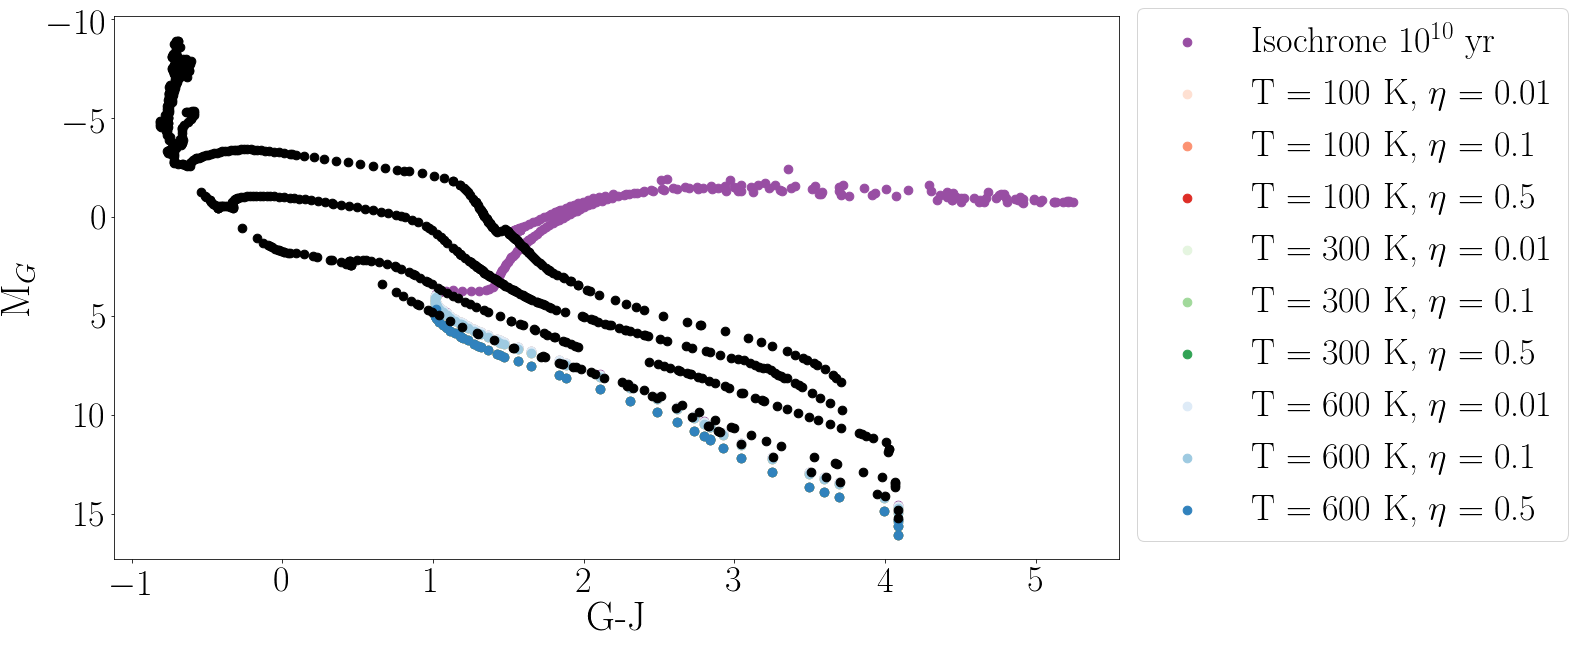

In [26]:
fig, ax = plt.subplots(figsize=(18,10))

matplotlib.rcParams.update({'font.size': 36})

ax.scatter(G6-J6,G6,label=r'Isochrone 10$^{10}$ yr',c='#984ea3',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)

ax.scatter(G_DS(gms6,100,10**L6[ms6],0.01)-J_DS(jms6,100,10**(L6[ms6]),0.01),G_DS(gms6,100,10**L6[ms6],0.01),label = 'T = 100 K, $\eta$ = 0.01',c='#fee0d2',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,100,10**L6[ms6],0.1)-J_DS(jms6,100,10**(L6[ms6]),0.1),G_DS(gms6,100,10**L6[ms6],0.1),label = 'T = 100 K, $\eta$ = 0.1',c='#fc9272',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,100,10**L6[ms6],0.5)-J_DS(jms6,100,10**(L6[ms6]),0.5),G_DS(gms6,100,10**L6[ms6],0.5),label = 'T = 100 K, $\eta$ = 0.5',c='#de2d26',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(G_DS(gms6,300,10**L6[ms6],0.01)-J_DS(jms6,300,10**(L6[ms6]),0.01),G_DS(gms6,300,10**L6[ms6],0.01),label = 'T = 300 K, $\eta$ = 0.01',c='#e5f5e0',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,300,10**L6[ms6],0.1)-J_DS(jms6,300,10**(L6[ms6]),0.1),G_DS(gms6,300,10**L6[ms6],0.1),label = 'T = 300 K, $\eta$ = 0.1',c='#a1d99b',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,300,10**L6[ms6],0.5)-J_DS(jms6,300,10**(L6[ms6]),0.5),G_DS(gms6,300,10**L6[ms6],0.5),label = 'T = 300 K, $\eta$ = 0.5',c='#31a354',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(G_DS(gms6,600,10**L6[ms6],0.01)-J_DS(jms6,600,10**(L6[ms6]),0.01),G_DS(gms6,600,10**L6[ms6],0.01),label = 'T = 600 K, $\eta$ = 0.01',c='#deebf7',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,600,10**L6[ms6],0.1)-J_DS(jms6,600,10**(L6[ms6]),0.1),G_DS(gms6,600,10**L6[ms6],0.1),label = 'T = 600 K, $\eta$ = 0.1',c='#9ecae1',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,600,10**L6[ms6],0.5)-J_DS(jms6,600,10**(L6[ms6]),0.5),G_DS(gms6,600,10**L6[ms6],0.5),label = 'T = 600 K, $\eta$ = 0.5',c='#3182bd',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(gpms1-jpms1,gpms1,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms2-jpms2,gpms2,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms3-jpms3,gpms3,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms4-jpms4,gpms4,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms5-jpms5,gpms5,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)

ax.invert_yaxis()
ax.set_xlabel('G-J',size=40)
ax.set_ylabel('M$_{G}$',size=40)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.525))
#plt.savefig("stuff.pdf", bbox_inches='tight')
#files.download("stuff.pdf")
plt.show()
plt.close()

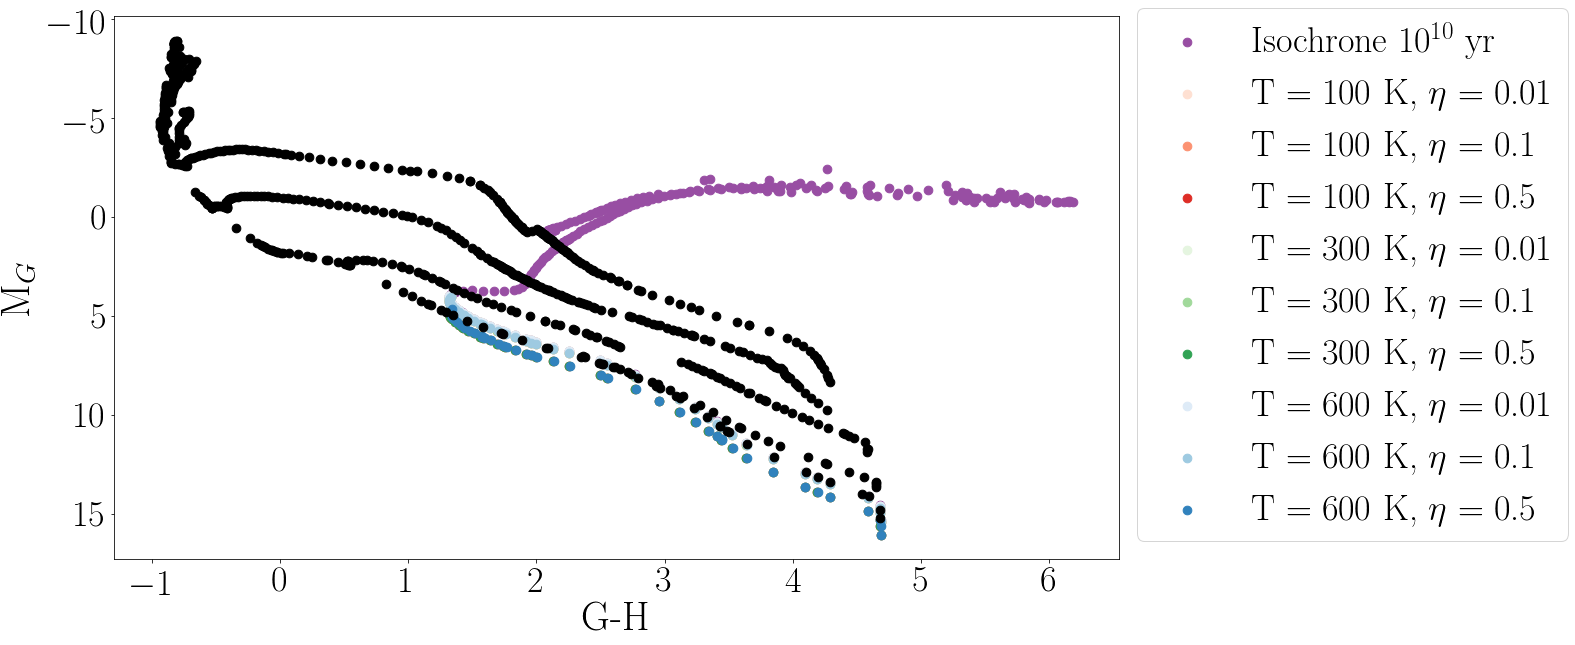

In [29]:
fig, ax = plt.subplots(figsize=(18,10))

matplotlib.rcParams.update({'font.size': 36})

ax.scatter(G6-H6,G6,label=r'Isochrone 10$^{10}$ yr',c='#984ea3',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)

ax.scatter(G_DS(gms6,100,10**L6[ms6],0.01)-H_DS(hms6,100,10**(L6[ms6]),0.01),G_DS(gms6,100,10**L6[ms6],0.01),label = 'T = 100 K, $\eta$ = 0.01',c='#fee0d2',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,100,10**L6[ms6],0.1)-H_DS(hms6,100,10**(L6[ms6]),0.1),G_DS(gms6,100,10**L6[ms6],0.1),label = 'T = 100 K, $\eta$ = 0.1',c='#fc9272',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,100,10**L6[ms6],0.5)-H_DS(hms6,100,10**(L6[ms6]),0.5),G_DS(gms6,100,10**L6[ms6],0.5),label = 'T = 100 K, $\eta$ = 0.5',c='#de2d26',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(G_DS(gms6,300,10**L6[ms6],0.01)-H_DS(hms6,300,10**(L6[ms6]),0.01),G_DS(gms6,300,10**L6[ms6],0.01),label = 'T = 300 K, $\eta$ = 0.01',c='#e5f5e0',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,300,10**L6[ms6],0.1)-H_DS(hms6,300,10**(L6[ms6]),0.1),G_DS(gms6,300,10**L6[ms6],0.1),label = 'T = 300 K, $\eta$ = 0.1',c='#a1d99b',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,300,10**L6[ms6],0.5)-H_DS(hms6,300,10**(L6[ms6]),0.5),G_DS(gms6,300,10**L6[ms6],0.5),label = 'T = 300 K, $\eta$ = 0.5',c='#31a354',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(G_DS(gms6,600,10**L6[ms6],0.01)-H_DS(hms6,600,10**(L6[ms6]),0.01),G_DS(gms6,600,10**L6[ms6],0.01),label = 'T = 600 K, $\eta$ = 0.01',c='#deebf7',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,600,10**L6[ms6],0.1)-H_DS(hms6,600,10**(L6[ms6]),0.1),G_DS(gms6,600,10**L6[ms6],0.1),label = 'T = 600 K, $\eta$ = 0.1',c='#9ecae1',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,600,10**L6[ms6],0.5)-H_DS(hms6,600,10**(L6[ms6]),0.5),G_DS(gms6,600,10**L6[ms6],0.5),label = 'T = 600 K, $\eta$ = 0.5',c='#3182bd',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(gpms1-hpms1,gpms1,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms2-hpms2,gpms2,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms3-hpms3,gpms3,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms4-hpms4,gpms4,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms5-hpms5,gpms5,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)

ax.invert_yaxis()
ax.set_xlabel('G-H',size=40)
ax.set_ylabel('M$_{G}$',size=40)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.525))
#plt.savefig("stuff.pdf", bbox_inches='tight')
#files.download("stuff.pdf")
plt.show()
plt.close()

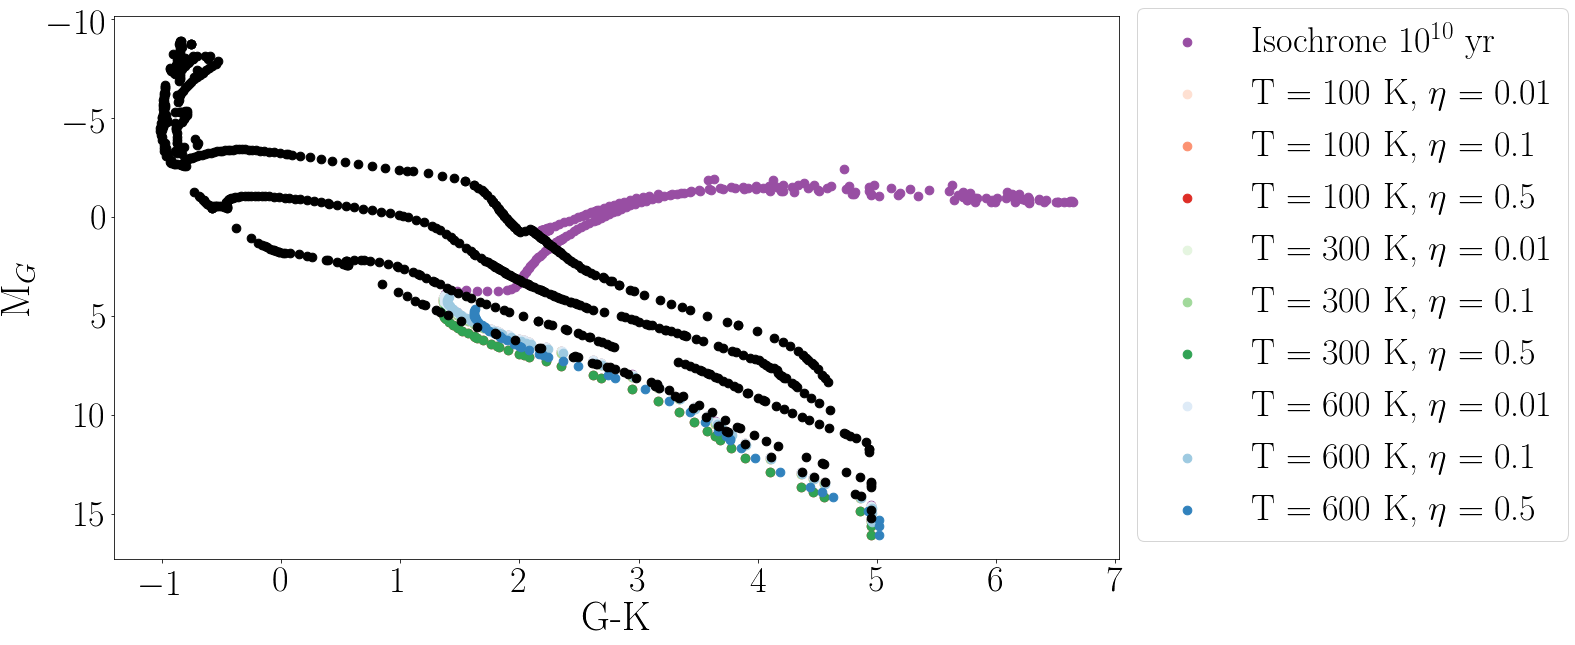

In [24]:
fig, ax = plt.subplots(figsize=(18,10))

matplotlib.rcParams.update({'font.size': 36})

ax.scatter(G6-K6,G6,label=r'Isochrone 10$^{10}$ yr',c='#984ea3',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)

ax.scatter(G_DS(gms6,100,10**L6[ms6],0.01)-K_DS(kms6,100,10**(L6[ms6]),0.01),G_DS(gms6,100,10**L6[ms6],0.01),label = 'T = 100 K, $\eta$ = 0.01',c='#fee0d2',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,100,10**L6[ms6],0.1)-K_DS(kms6,100,10**(L6[ms6]),0.1),G_DS(gms6,100,10**L6[ms6],0.1),label = 'T = 100 K, $\eta$ = 0.1',c='#fc9272',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,100,10**L6[ms6],0.5)-K_DS(kms6,100,10**(L6[ms6]),0.5),G_DS(gms6,100,10**L6[ms6],0.5),label = 'T = 100 K, $\eta$ = 0.5',c='#de2d26',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(G_DS(gms6,300,10**L6[ms6],0.01)-K_DS(kms6,300,10**(L6[ms6]),0.01),G_DS(gms6,300,10**L6[ms6],0.01),label = 'T = 300 K, $\eta$ = 0.01',c='#e5f5e0',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,300,10**L6[ms6],0.1)-K_DS(kms6,300,10**(L6[ms6]),0.1),G_DS(gms6,300,10**L6[ms6],0.1),label = 'T = 300 K, $\eta$ = 0.1',c='#a1d99b',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,300,10**L6[ms6],0.5)-K_DS(kms6,300,10**(L6[ms6]),0.5),G_DS(gms6,300,10**L6[ms6],0.5),label = 'T = 300 K, $\eta$ = 0.5',c='#31a354',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(G_DS(gms6,600,10**L6[ms6],0.01)-K_DS(kms6,600,10**(L6[ms6]),0.01),G_DS(gms6,600,10**L6[ms6],0.01),label = 'T = 600 K, $\eta$ = 0.01',c='#deebf7',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,600,10**L6[ms6],0.1)-K_DS(kms6,600,10**(L6[ms6]),0.1),G_DS(gms6,600,10**L6[ms6],0.1),label = 'T = 600 K, $\eta$ = 0.1',c='#9ecae1',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250
ax.scatter(G_DS(gms6,600,10**L6[ms6],0.5)-K_DS(kms6,600,10**(L6[ms6]),0.5),G_DS(gms6,600,10**L6[ms6],0.5),label = 'T = 600 K, $\eta$ = 0.5',c='#3182bd',s=75)#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=250

ax.scatter(gpms1-kpms1,gpms1,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms2-kpms2,gpms2,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms3-kpms3,gpms3,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms4-kpms4,gpms4,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)
ax.scatter(gpms5-kpms5,gpms5,c='k',s=75) #,label='1e6 yr')#,cmap='magma')#,alpha=0.5,vmax=28000,vmin=2500)

ax.invert_yaxis()
ax.set_xlabel('G-K',size=40)
ax.set_ylabel('M$_{G}$',size=40)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.525))
#plt.savefig("stuff.pdf", bbox_inches='tight')
#files.download("stuff.pdf")
plt.show()
plt.close()